In [1]:
import msprime
import sys
import numpy as np
import seaborn as sns
from IPython.display import SVG
import matplotlib.pyplot as plt
from itertools import chain

In [2]:
pop_configs = [
    msprime.PopulationConfiguration(sample_size=100, growth_rate = 0),
    msprime.PopulationConfiguration(sample_size=100, growth_rate = 0),
    msprime.PopulationConfiguration(sample_size=100, growth_rate = 0)]

divergence_event1 = msprime.MassMigration(time = 50, source = 1, dest = 0, proportion = 1)
divergence_event2 = msprime.MassMigration(time = 1000, source = 2, dest = 0, proportion = 1)
Ne = 100
recomb = 0.5
mutation_rate = 0.25
pops = [range(0,100),range(100,200),range(200,300)]
ts_ref = msprime.simulate(population_configurations = pop_configs,Ne = Ne,mutation_rate=mutation_rate,
                      demographic_events = [divergence_event1,divergence_event2],
                      random_seed = 1, recombination_rate = recomb)
ref_stat = ts_ref.f3([pops[2],pops[0],pops[1]])

Wall time: 33 ms


In [20]:
#ABC Function
def ABC_reg_adjustment(data,eps,pop_configs,pops,Ne,recomb,mutations,divergence2,prior ="exponential",prior_parameters=10,iters=1000):
    ref_stat = (data.f2([pops[0],pops[1]]),data.f3([pops[2],pops[0],pops[1]]),data.diversity())
    samples = []
    discrepancies = []
    if prior == "exponential":
        for iter in range(0,iterations):
            divergence_time = min(np.random.exponential(prior_parameters),1000)
            divergence_event1 = msprime.MassMigration(time = divergence_time, source = 1, dest = 0, proportion = 1)
            ts_sim = msprime.simulate(population_configurations = pop_configs,Ne=Ne, mutation_rate=mutation_rate,
                      demographic_events = [divergence_event1,divergence_event2],recombination_rate = recomb)
            sim_stat = (ts_sim.f2([pops[0],pops[1]]),ts_sim.f3([pops[2],pops[0],pops[1]]),ts_sim.diversity())
            if np.linalg.norm(np.subtract(ref_stat,sim_stat)) < eps:
                samples.append(divergence_time)
                discrepancies.append(np.subtract(sim_stat,ref_stat))
    if prior == "uniform":
        for iter in range(0,iterations):
            divergence_time = min(np.random.uniform(prior_parameters[0],prior_parameters[1]),1000)
            divergence_event1 = msprime.MassMigration(time = divergence_time, source = 1, dest = 0, proportion = 1)
            ts_sim = msprime.simulate(population_configurations = pop_configs,Ne=Ne, mutation_rate=mutation_rate,
                      demographic_events = [divergence_event1,divergence_event2],recombination_rate = recomb)
            sim_stat = (ts_sim.f2([pops[0],pops[1]]),ts_sim.f3([pops[2],pops[0],pops[1]]),ts_sim.diversity())
            if np.linalg.norm(np.subtract(ref_stat,sim_stat)) < eps:
                samples.append(divergence_time)
                discrepancies.append(np.subtract(sim_stat,ref_stat))
    X = np.zeros((len(samples),len(ref_stat)+1))
    for i in range(len(samples)):
        for j in range(len(ref_stat)+1):
            if j == 0:
                X[i][j]=1
            else:
                X[i][j]= discrepancies[i][j-1]
    adjusted_samples = np.subtract(samples,np.dot(np.array(discrepancies),np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,np.array(samples)))[1:]))
    return(adjusted_samples)

Exponential prior rate 40, $\epsilon$ = 10

In [31]:
%%time

iterations = 10000
eps = 10
prior= "exponential"
prior_parameters = 40
attempt1 = ABC_reg_adjustment(ts_ref,eps=eps,pop_configs=pop_configs,pops=pops,Ne=Ne,recomb=recomb,mutations=mutation_rate,divergence2 = divergence_event2,prior=prior,prior_parameters=prior_parameters,iters=iterations)

Wall time: 5min 6s


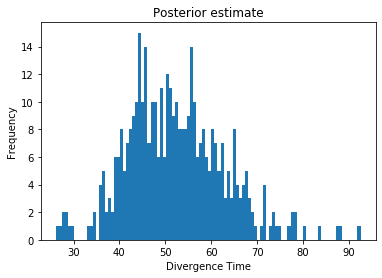

Acceptance probability : 0.0395


In [32]:
plt.hist(attempt1, bins = 100)
plt.ylabel('Frequency')
plt.xlabel('Divergence Time')
plt.title('Posterior estimate')
plt.show()
print("Acceptance probability :",len(attempt1)/iterations)

Exponential prior rate 40, $\epsilon$ increased to 50, since regression adjustment is $\epsilon$ insensitive. Estimated posterior is very good!

In [27]:
%%time
#Exponential prior rate 40, epsilon increased to 50
iterations = 10000
eps = 50
prior= "exponential"
prior_parameters = 40
attempt2 = ABC_reg_adjustment(ts_ref,eps=eps,pop_configs=pop_configs,pops=pops,Ne=Ne,recomb=recomb,mutations=mutation_rate,divergence2 = divergence_event2,prior=prior,prior_parameters=prior_parameters,iters=iterations)

Wall time: 5min 11s


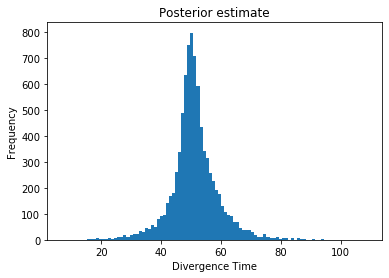

Acceptance probability : 0.8586


In [28]:
plt.hist(attempt2, bins = 100)
plt.ylabel('Frequency')
plt.xlabel('Divergence Time')
plt.title('Posterior estimate')
plt.show()
print("Acceptance probability :",len(attempt2)/iterations)

Uniform(1,500) prior, with $\epsilon$ = 50. Estimated posterior is good but somewhat skewed by the prior

In [29]:
%%time
#Uniform(1,500) prior, epsilon increased to 50
iterations = 10000
eps = 50
prior= "uniform"
prior_parameters = (1,500)
attempt3 = ABC_reg_adjustment(ts_ref,eps=eps,pop_configs=pop_configs,pops=pops,Ne=Ne,recomb=recomb,mutations=mutation_rate,divergence2 = divergence_event2,prior=prior,prior_parameters=prior_parameters,iters=iterations)

Wall time: 5min 47s


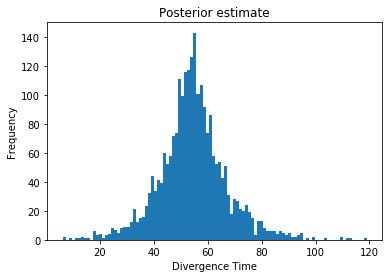

Acceptance probability : 0.2413


In [30]:
plt.hist(attempt3, bins = 100)
plt.ylabel('Frequency')
plt.xlabel('Divergence Time')
plt.title('Posterior estimate')
plt.show()
print("Acceptance probability :",len(attempt3)/iterations)

In [33]:
%%time
#Uniform(1,500) prior, epsilon increased to 50
iterations = 10000
eps = 100
prior= "uniform"
prior_parameters = (1,500)
attempt4 = ABC_reg_adjustment(ts_ref,eps=eps,pop_configs=pop_configs,pops=pops,Ne=Ne,recomb=recomb,mutations=mutation_rate,divergence2 = divergence_event2,prior=prior,prior_parameters=prior_parameters,iters=iterations)

Wall time: 5min 48s


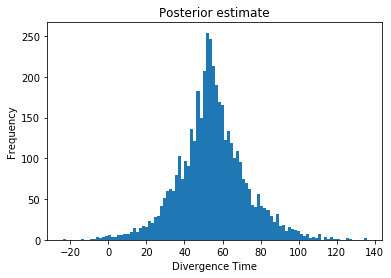

Acceptance probability : 0.436


In [34]:
plt.hist(attempt4, bins = 100)
plt.ylabel('Frequency')
plt.xlabel('Divergence Time')
plt.title('Posterior estimate')
plt.show()
print("Acceptance probability :",len(attempt4)/iterations)